# Bayesian parameter estimation for an LG-SSM using HMC

We show how to use the [blackjax](https://github.com/blackjax-devs/blackjax) libray to compute the parameter posterior $p(\theta|y(1:T))$
for an LGSSM model. We use the Kalman filter to compute the marginal likelihood, $p(y(1:T) | \theta) = \int_{z(1:T)} p(z(1:T), y(1:T)|\theta)$.



## Setup

In [1]:
import sys
%matplotlib inline
sys.path.append("../../..")
sys.path.append("../..")

import dynamax

from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from matplotlib import pyplot as plt


# use custom src codebase
from utils.plotting_utils import *

# from utils.utils import monotonically_increasing
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import (
    LearnableFunction,
    ConstantLearnableFunction,
    LinearLearnableFunction,
)

import blackjax


/opt/homebrew/anaconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.parameters import log_det_jac_constrain

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

## Generate synthetic training data

In [3]:
# Simulate synthetic data from true model
state_dim = 2
emission_dim = 10
num_timesteps = 200
t_emissions = jnp.arange(num_timesteps)[:, None]
keys = map(jr.PRNGKey, count())

# Create a model with oscillatory dynamics
drift_weights = jnp.array([[0, -1], [1, 0]])

true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.initialize(
    next(keys),
    dynamics_drift=LinearLearnableFunction(params=drift_weights),
    dynamics_diffusion_coefficient=ConstantLearnableFunction(params=0.01*jnp.eye(state_dim)),
    dynamics_diffusion_cov=ConstantLearnableFunction(params=jnp.eye(state_dim)),
)

# sample true states and emissions. Using transition_type="path" to solve SDE.
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions)
true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions, transition_type="path")

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
state.shape (2,)


In [4]:
def plot_results(emissions, smoothed_emissions, smoothed_emissions_std):
    # all arrays are (T, E) dimensional, T=ntime, E=emission_dim
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emission_dim):
        plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                    label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            jnp.arange(num_timesteps),
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[:, i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, num_timesteps - 1)
    plt.ylabel("true and predicted emissions")
    plt.legend()

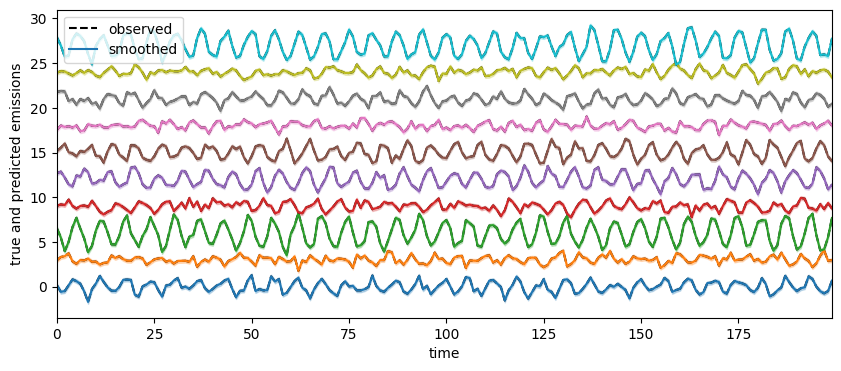

In [5]:
plot_results(emissions, emissions, 0.1*jnp.ones_like(emissions)) # fake posterior variance

## Baseline method: use SGD to compute MLE

In [6]:
# Initilize parameters by fitting SGD algorithm
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams
from continuous_discrete_nonlinear_gaussian_ssm.models import LearnableFunction,ConstantLearnableFunction,LinearLearnableFunction
num_epochs = 4000

filter_hyperparams = EKFHyperParams()
test_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
initial_params, param_props = test_model.initialize(next(keys))
# fitted_params, marginal_lls = test_model.fit_em(initial_params, param_props, emissions, num_iters=num_iters)
fitted_params, marginal_lls = test_model.fit_sgd(
    initial_params,
    param_props,
    emissions,
    filter_hyperparams=filter_hyperparams,
    t_emissions=t_emissions,
    num_epochs=num_epochs,
)


In [7]:
# Extract fitted params
fitted_C = fitted_params.emissions.emission_function.params
# fitted_d = fitted_params.emissions.bias
fitted_d = 0
fitted_R = fitted_params.emissions.emission_cov.params

# Compute predicted emissions
filtered_posterior = cdnlgssm_filter(
    fitted_params, emissions=emissions, hyperparams=filter_hyperparams, t_emissions=t_emissions
)
filtered_emissions_mean = filtered_posterior.filtered_means @ fitted_C.T + fitted_d
filtered_emissions_cov = fitted_C @ filtered_posterior.filtered_covariances @ fitted_C.T + fitted_R
filtered_emissions_std = jnp.sqrt(jnp.array([filtered_emissions_cov[:, i, i] for i in range(emission_dim)])).T  # (T,E)

Text(0.5, 1.0, 'Marginal log likelihood over iterations')

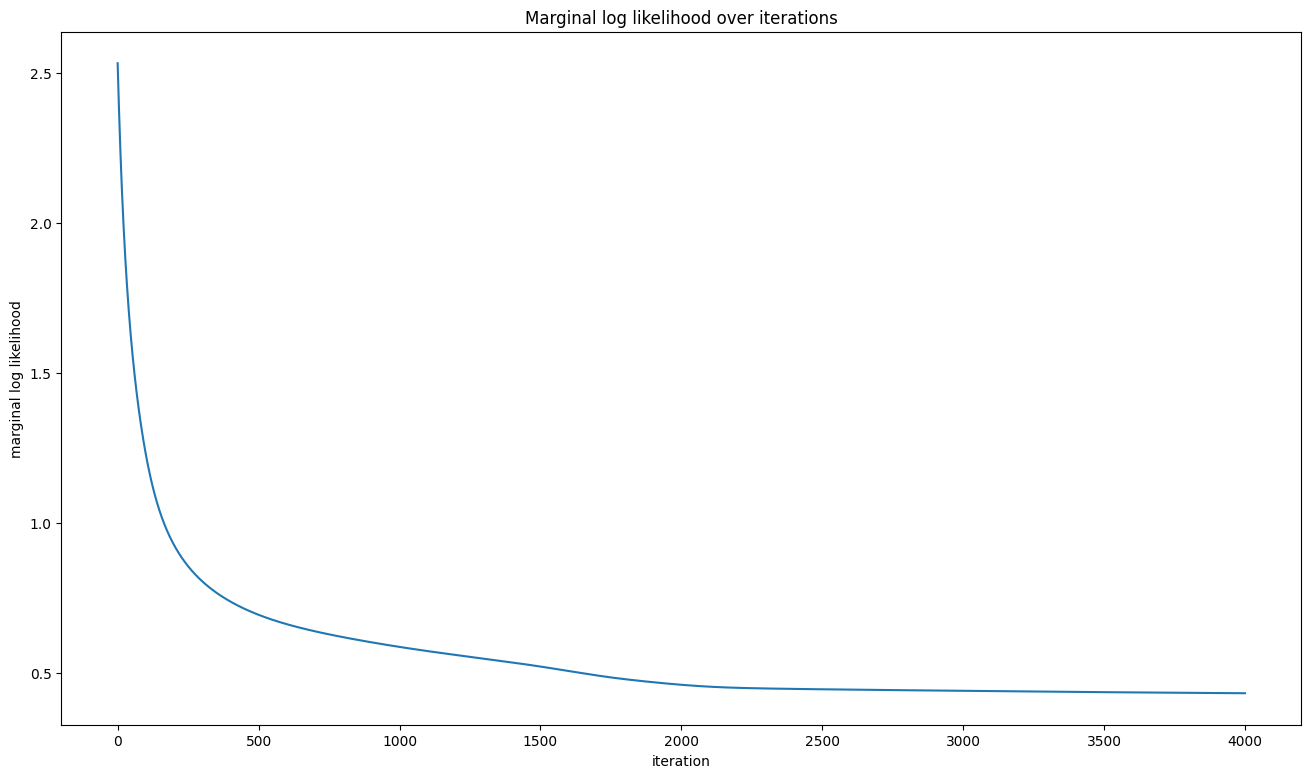

In [8]:
# plot the marginal lls over iterations for SGD
plt.plot(marginal_lls)
plt.xlabel("iteration")
plt.ylabel("marginal log likelihood")
# plt.autoscale(enable=True, axis="x", tight=True)
plt.title("Marginal log likelihood over iterations")

[(200, 10), (200, 10), (200, 10)]


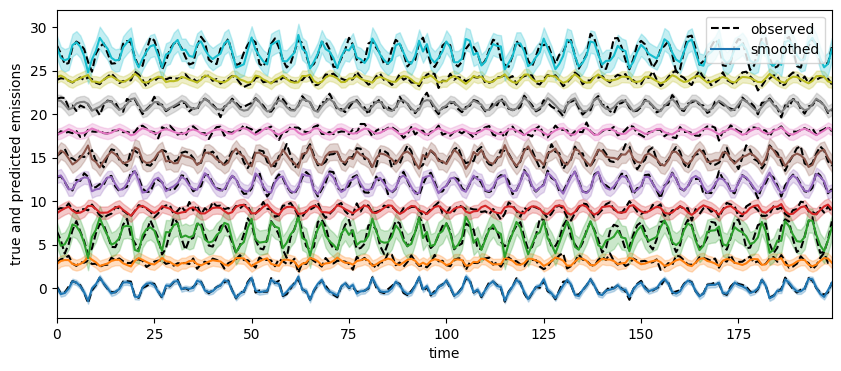

In [9]:
print([emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])
plot_results(emissions, filtered_emissions_mean, filtered_emissions_std)


## Implement HMC wrapper

In [10]:
from dynamax.parameters import to_unconstrained, from_unconstrained
from dynamax.utils.utils import pytree_stack, ensure_array_has_batch_dim
from functools import partial
from fastprogress.fastprogress import progress_bar


def fit_hmc(
    model,
    initial_params,
    props,
    key,
    num_samples,
    emissions,
    filter_hyperparams,
    inputs=None,
    warmup_steps=100,
    num_integration_steps=30,
    verbose=True,
):
    """Sample parameters of the model using HMC."""
    # Make sure the emissions and inputs have batch dimensions
    batch_emissions = ensure_array_has_batch_dim(emissions, model.emission_shape)
    batch_inputs = ensure_array_has_batch_dim(inputs, model.inputs_shape)

    initial_unc_params = to_unconstrained(initial_params, props)

    # The log likelihood that the HMC samples from
    def _logprob(unc_params):
        params = from_unconstrained(unc_params, props)
        batch_lls = vmap(partial(model.marginal_log_prob, params, filter_hyperparams))(batch_emissions, batch_inputs)
        lp = model.log_prior(params) + batch_lls.sum()
        lp += log_det_jac_constrain(params, props)
        return lp

    # Initialize the HMC sampler using window_adaptation
    warmup = blackjax.window_adaptation(blackjax.hmc,
                                        _logprob,
                                        num_steps=warmup_steps,
                                        num_integration_steps=num_integration_steps,
                                        progress_bar=verbose)
    init_key, key = jr.split(key)
    hmc_initial_state, hmc_kernel, _ = warmup.run(init_key, initial_unc_params)

    @jit
    def hmc_step(hmc_state, step_key):
        next_hmc_state, _ = hmc_kernel(step_key, hmc_state)
        params = from_unconstrained(hmc_state.position, props)
        return next_hmc_state, params

    # Start sampling
    log_probs = []
    samples = []
    hmc_state = hmc_initial_state
    pbar = progress_bar(range(num_samples)) if verbose else range(num_samples)
    for _ in pbar:
        step_key, key = jr.split(key)
        hmc_state, params = hmc_step(hmc_state, step_key)
        log_probs.append(-hmc_state.potential_energy)
        samples.append(params)

    # Combine the samples into a single pytree
    return pytree_stack(samples), jnp.array(log_probs)

In [11]:
@jit
def filter_emission(params):
    C = params.emissions.emission_function.params
    # d = params.emissions.bias
    d = 0
    filtered_posterior = cdnlgssm_filter(
        params, emissions=emissions, hyperparams=filter_hyperparams, t_emissions=t_emissions
    )

    return filtered_posterior.filtered_means @ C.T + d    





In [12]:
import matplotlib.pyplot as plt
import numpy as np


def plot_param_distributions(samples, true, sgd, name='', burn_in_frac=0.5):
    """
    Plots N_params horizontal box plots for the given N_params x N_samples matrix.

    Parameters:
    - samples: N_params x N_samples matrix of parameter samples.
    - true: N_params array of true parameter values.
    - sgd: N_params array of SGD estimates.
    - name: Name of the parameter set.
    - burn_in_frac: Fraction of samples to discard as burn-in.

    Returns:
    - A matplotlib figure with N_params horizontal box plots.
    """
    N_params = samples.shape[0]
    fig, ax = plt.subplots(figsize=(10, N_params * 2))  # Adjust figure size based on number of parameters

    # apply burn-in
    burn_in = int(burn_in_frac * samples.shape[1])
    samples = samples[:, burn_in:]
    
    # Create box plots
    ax.boxplot(samples, vert=False, patch_artist=True)

    # Set the y-axis labels to show parameter indices
    ax.set_yticks(range(1, N_params + 1))
    ax.set_yticklabels(["Parameter {}".format(i + 1) for i in range(N_params)])

    # Plot ground truth and estimates
    ax.scatter(sgd, range(1, N_params + 1), color="magenta", marker="o", s=100, label="SGD Estimate", zorder=3)
    ax.scatter(true, range(1, N_params + 1), color="red", marker="x", s=100, label="Ground Truth", zorder=4)

    plt.xlabel("Value")
    plt.ylabel("Parameters")
    plt.title("{} Parameter Distributions".format(name))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_all(param_samples, burn_in_frac=0.5):
    """
    Plots the posterior distributions of all parameters.
    Burn-in is removed from the samples.
    """
    plot_param_distributions(
        param_samples.initial.mean.T, true_params.initial.mean, fitted_params.initial.mean, name="Initial mean",
        burn_in_frac=burn_in_frac
    )
    plot_param_distributions(
        param_samples.initial.cov.reshape(-1, param_samples.initial.cov.shape[0]),
        true_params.initial.cov.flatten(),
        fitted_params.initial.cov.flatten(),
        name="Initial cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.params.reshape(-1, param_samples.dynamics.drift.params.shape[0]),
        true_params.dynamics.drift.params,
        fitted_params.dynamics.drift.params,
        name="Dynamics drift",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_cov.params.reshape(-1, param_samples.dynamics.diffusion_cov.params.shape[0]),
        true_params.dynamics.diffusion_cov.params.flatten(),
        fitted_params.dynamics.diffusion_cov.params.flatten(),
        name="Dynamics diffusion cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_coefficient.params.reshape(
            -1, param_samples.dynamics.diffusion_coefficient.params.shape[0]
        ),
        true_params.dynamics.diffusion_coefficient.params.flatten(),
        fitted_params.dynamics.diffusion_coefficient.params.flatten(),
        name="Dynamics diffusion coefficient",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.params.reshape(
            -1, param_samples.emissions.emission_function.params.shape[0]
        ),
        true_params.emissions.emission_function.params.flatten(),
        fitted_params.emissions.emission_function.params.flatten(),
        name="Emissions function",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_cov.params.reshape(-1, param_samples.emissions.emission_cov.params.shape[0]),
        true_params.emissions.emission_cov.params.flatten(),
        fitted_params.emissions.emission_cov.params.flatten(),
        name="Emissions cov",
        burn_in_frac=burn_in_frac,
    )

## Call HMC

In [13]:
# Now, run HMC initialized using the SGD-fitted parameters
sample_size = 500
param_samples, lps = fit_hmc(
    test_model,
    fitted_params, #initial_params,
    param_props,
    next(keys),
    sample_size,
    emissions,
    filter_hyperparams=filter_hyperparams,
    num_integration_steps=30,
)

Running window adaptation


Text(0.5, 0, 'log probability')

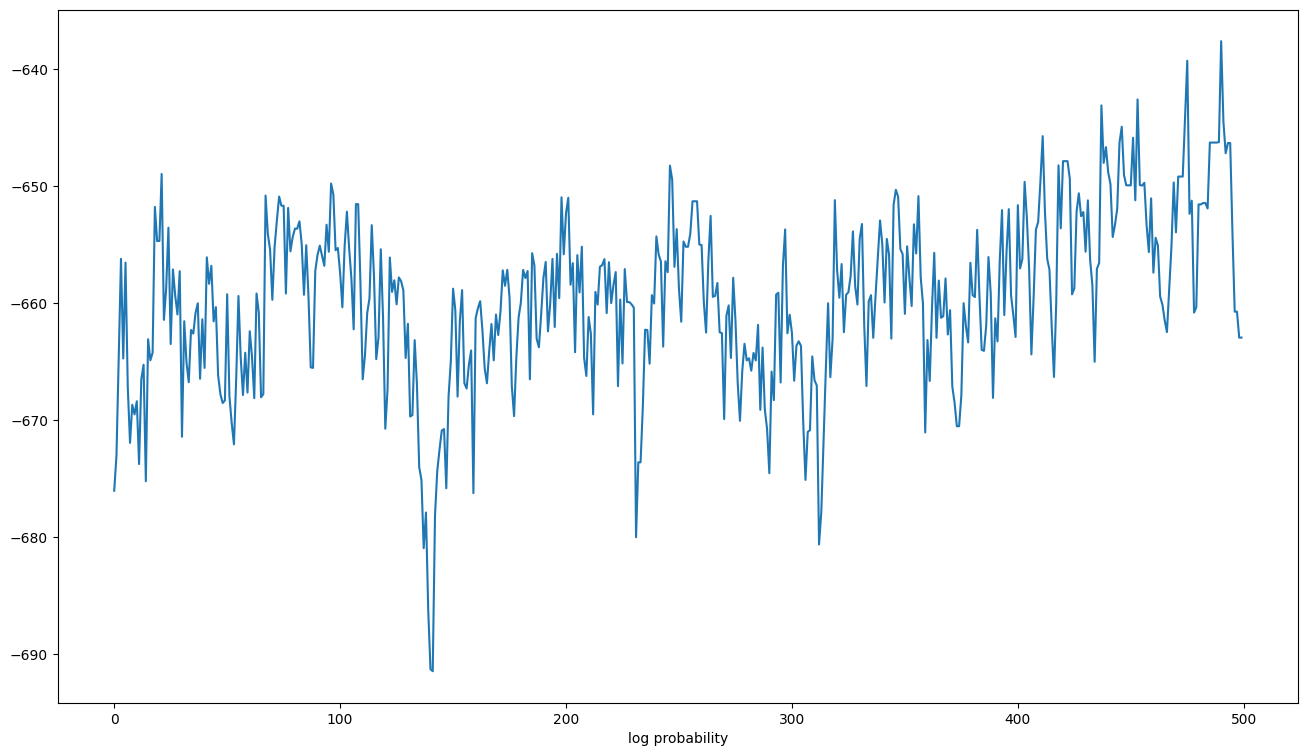

In [14]:
plt.plot(lps)
plt.xlabel("iteration")
plt.xlabel("log probability")

Text(0.5, 1.0, 'Eigenvalues of the drift matrix')

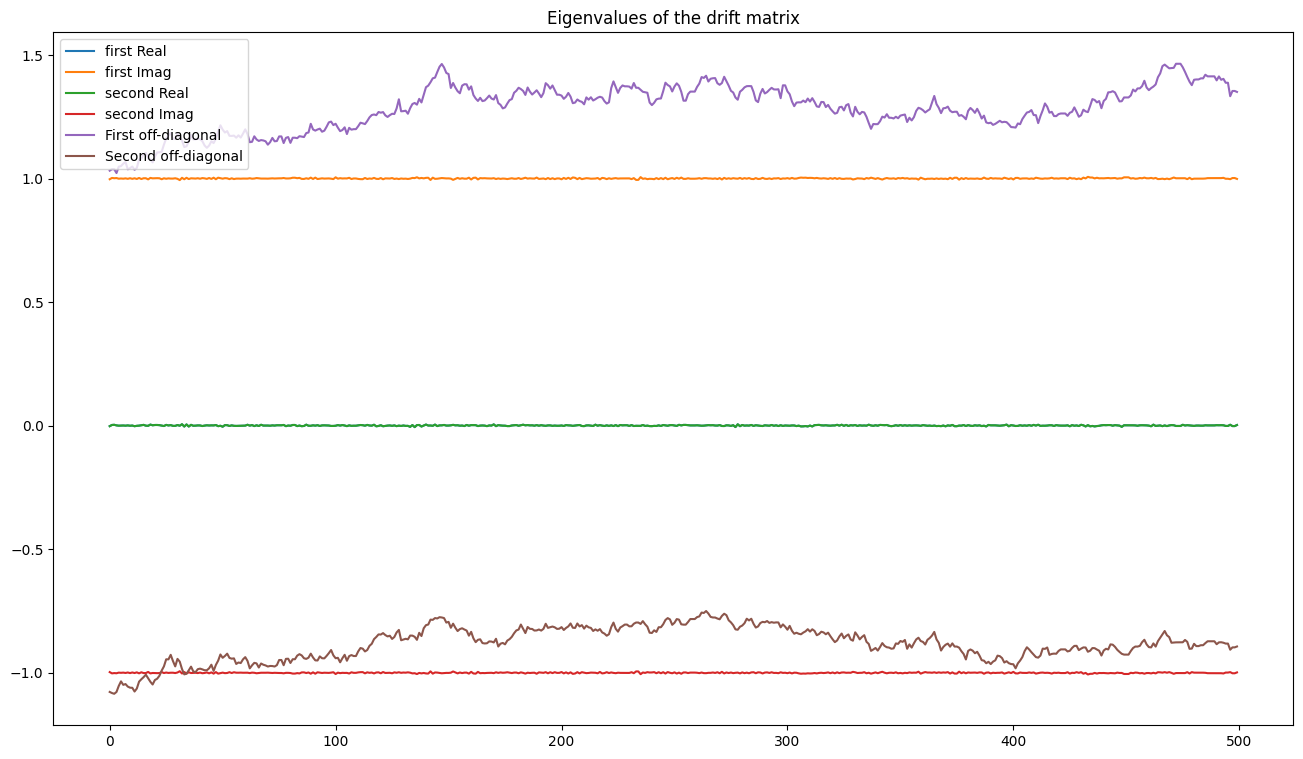

In [15]:
# compute eigenvalues of param_samples.dynamics.drift.params across samples using vmap

eigvals = vmap(jnp.linalg.eigvals)(param_samples.dynamics.drift.params)

# plot the complex part of the eigenvalues
plt.plot(eigvals.real[:, 0], label="first Real")
plt.plot(eigvals.imag[:, 0], label="first Imag")
plt.plot(eigvals.real[:, 1], label="second Real")
plt.plot(eigvals.imag[:, 1], label="second Imag")
plt.plot(param_samples.dynamics.drift.params[:, 1, 0], label="First off-diagonal")
plt.plot(param_samples.dynamics.drift.params[:, 0, 1], label="Second off-diagonal")
plt.legend()
plt.title("Eigenvalues of the drift matrix")

[(200, 10), (500, 200, 10), (200, 10), (200, 10)]


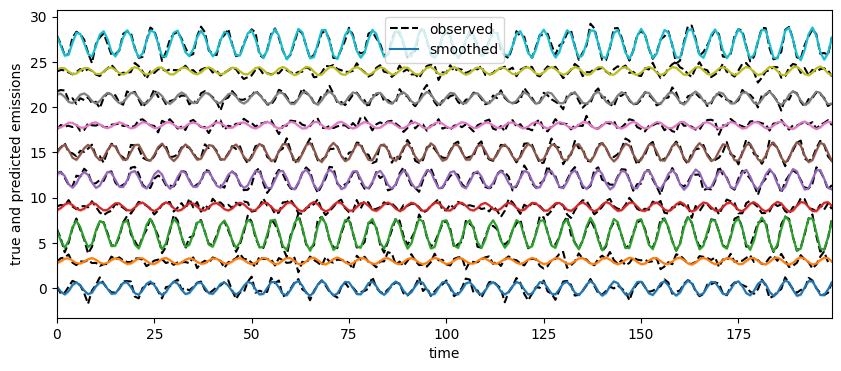

In [16]:
filtered_emissions = vmap(filter_emission)(param_samples)
filtered_emissions_mean = filtered_emissions.mean(axis=0)
filtered_emissions_std = jnp.std(filtered_emissions, axis=0)

# note that this shows a distribution of filtered means
# Unlike earlier plots, it does not show the filtered covariances, 
# which would add an appearance of greater uncertainty.
print([emissions.shape, filtered_emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])
plot_results(emissions, filtered_emissions_mean, filtered_emissions_std)

In [17]:
true_states[0], filtered_posterior.filtered_means[0]

(Array([0.47823134, 0.2494872 ], dtype=float32),
 Array([0.03469554, 0.6396265 ], dtype=float32))

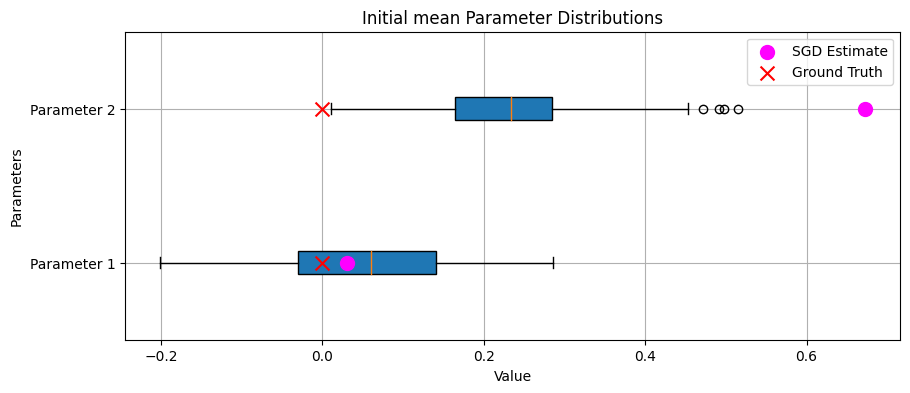

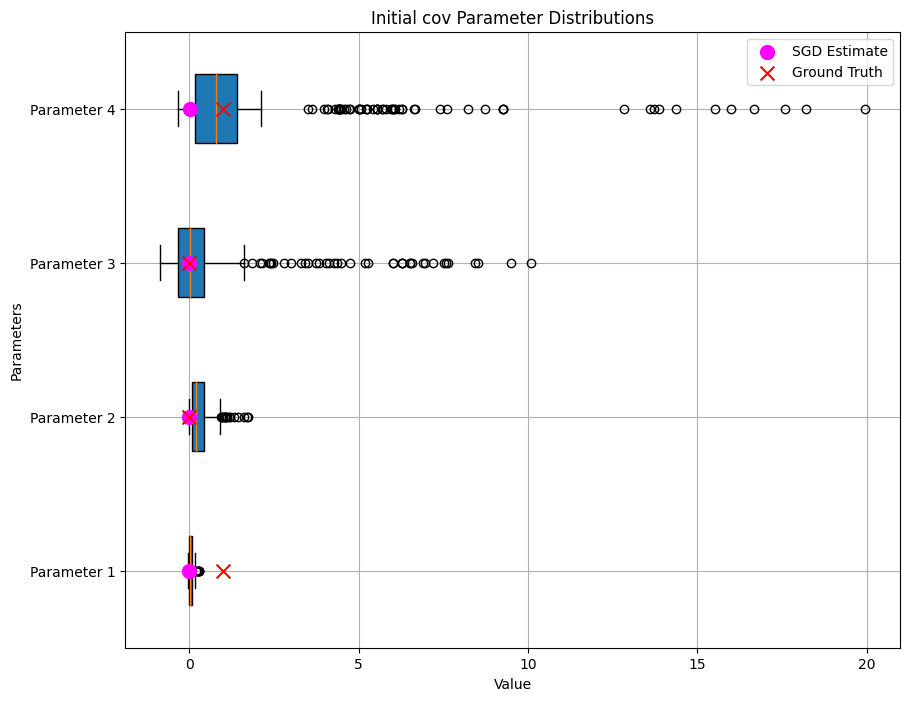

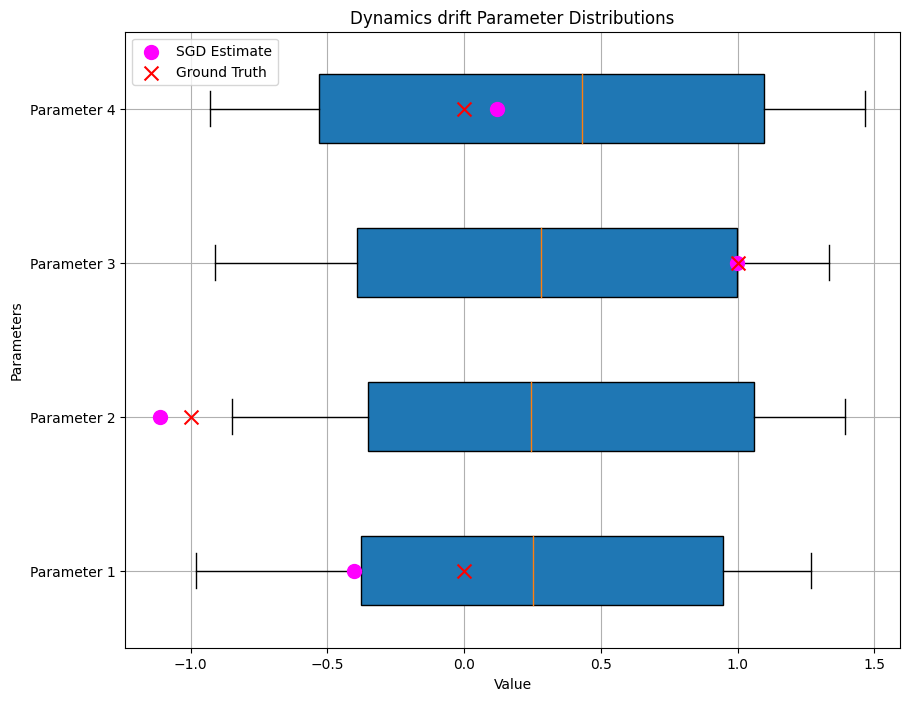

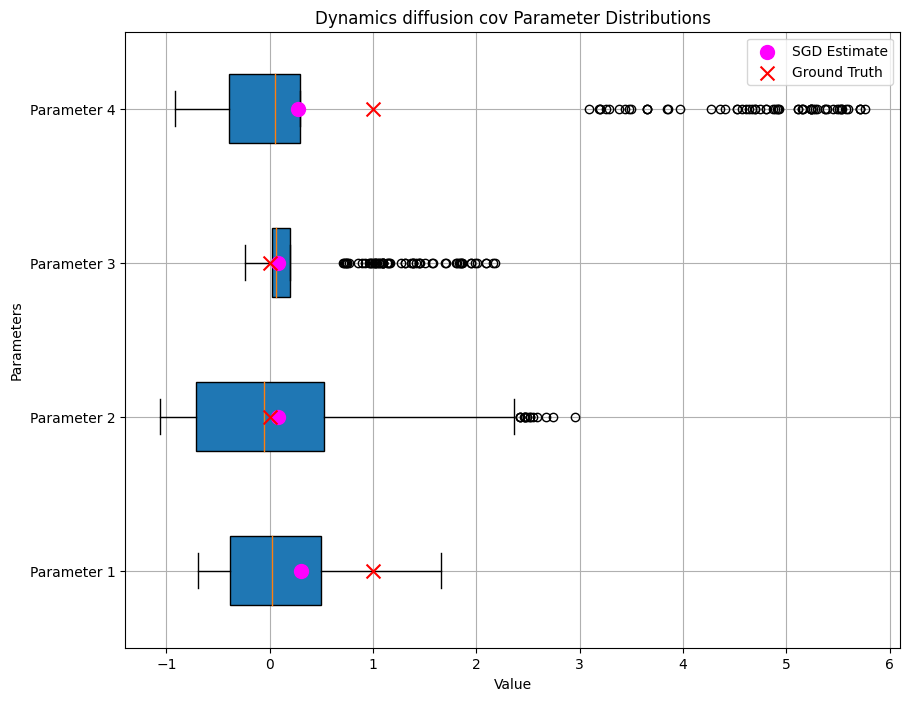

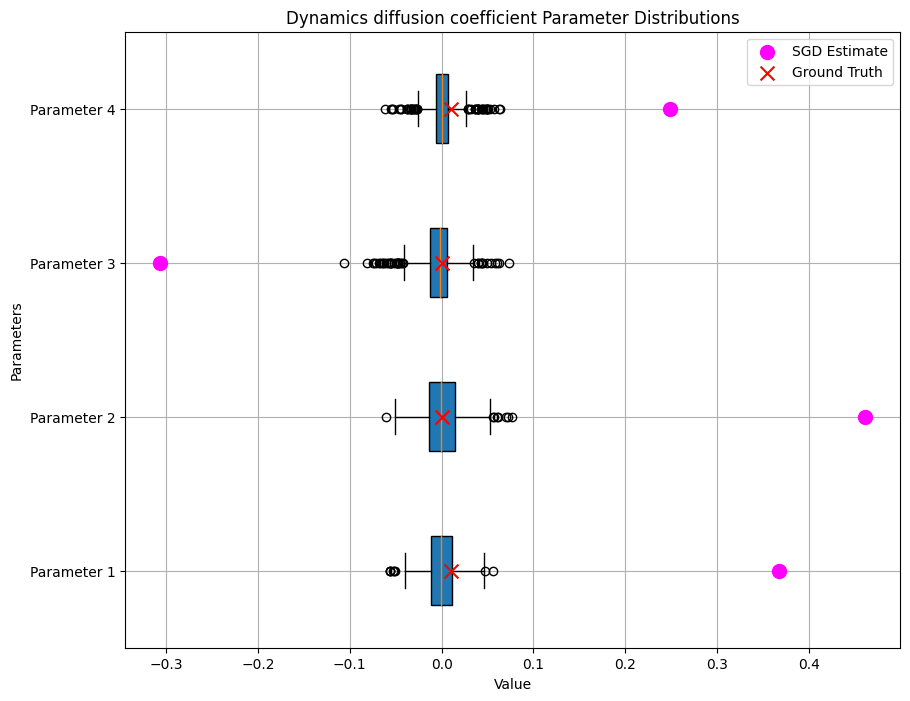

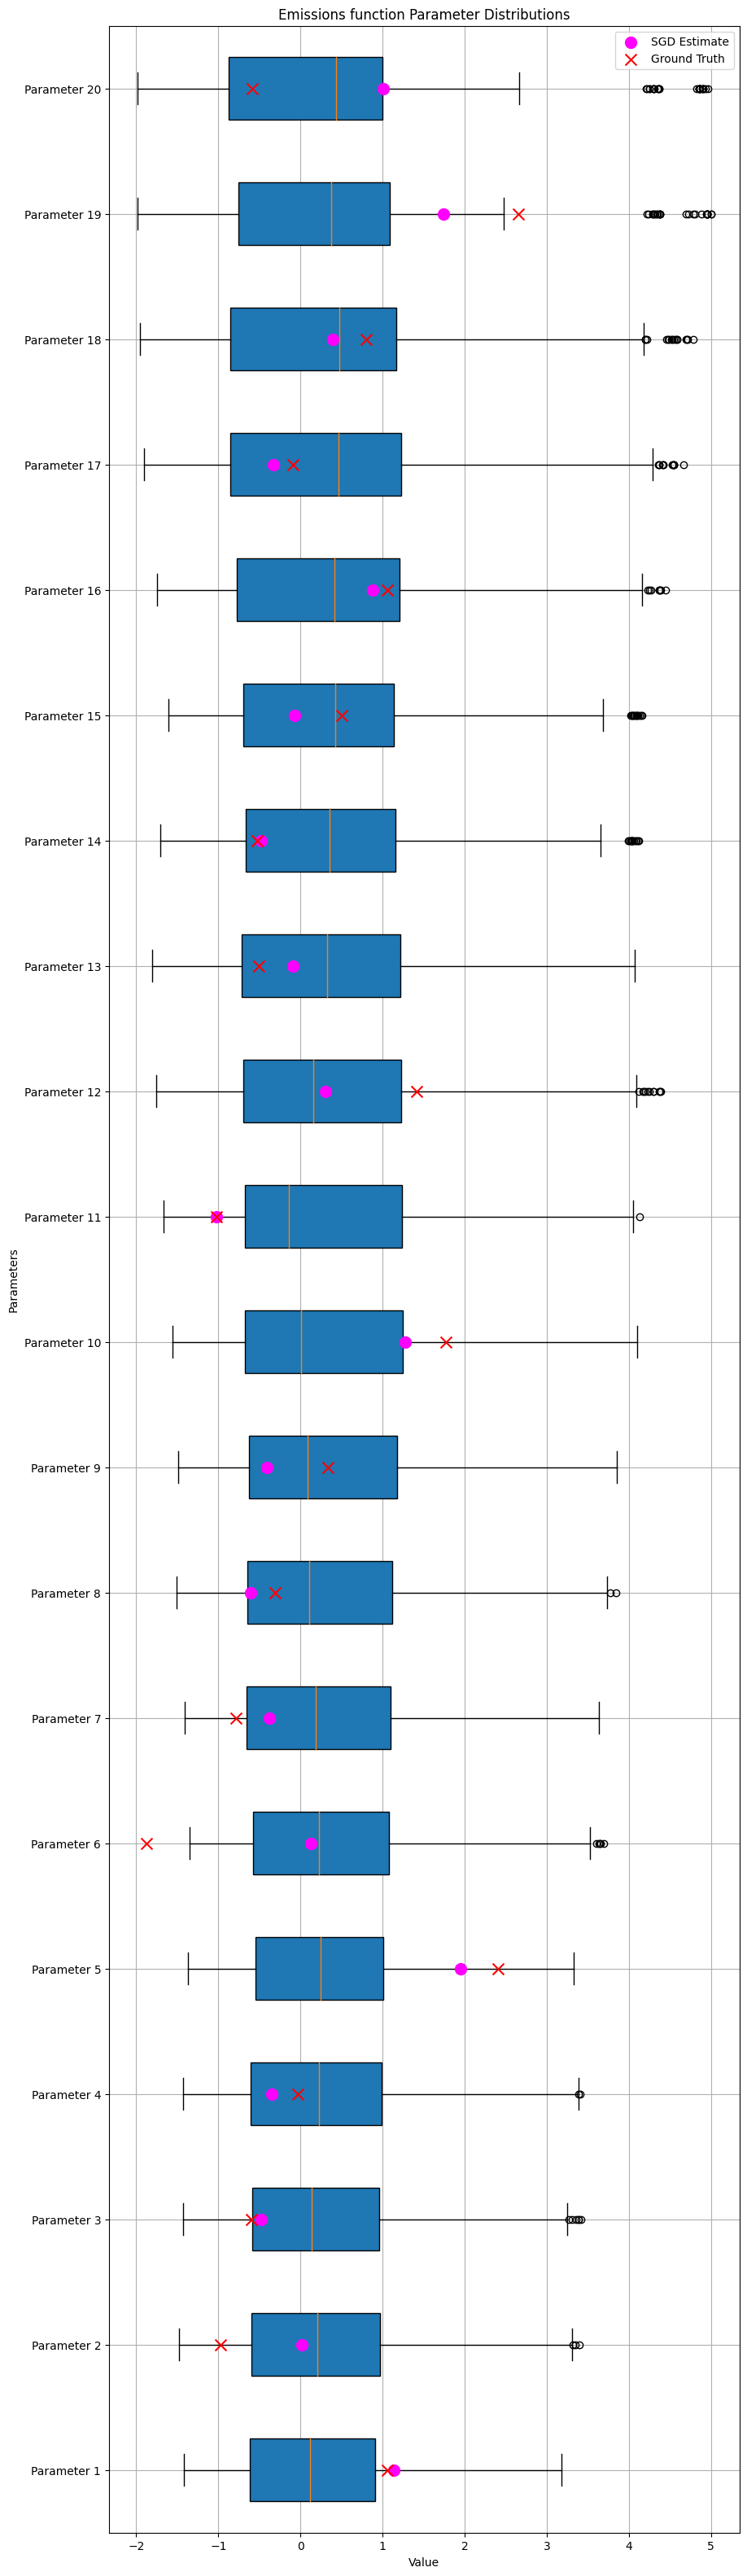

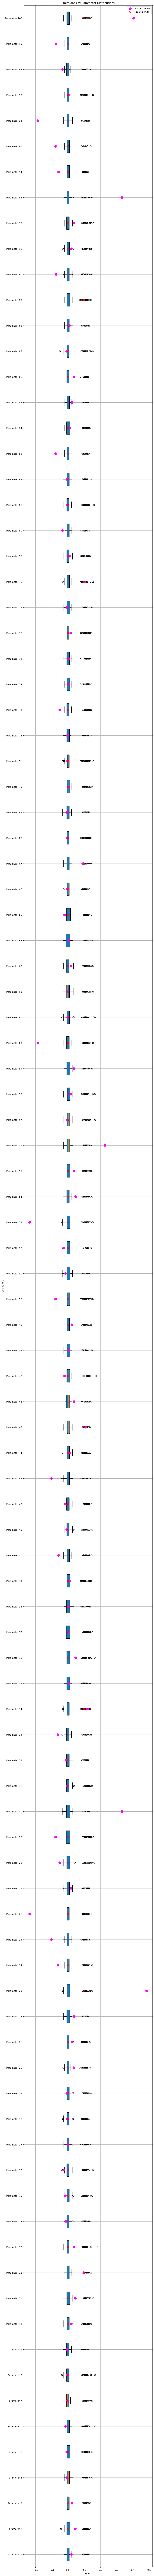

In [18]:
plot_all(param_samples)